In [88]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


그냥 shifh-enter 계속 누르면 다 합쳐집니다. 메모리 최적화는 되어있지 않은 상태입니다.

# 1. 데이터 만들기 

In [89]:
# 데이터 불러오기
def load_all():
    train_activity = pd.read_csv('./train_activity.csv')
    train_payment = pd.read_csv('./train_payment.csv')
    train_trade = pd.read_csv('./train_trade.csv')
    train_pledge = pd.read_csv('./train_pledge.csv')
    train_label = pd.read_csv('./train_label_add.csv')
    train_combat = pd.read_csv('./train_combat.csv')
    return train_activity, train_combat, train_payment, train_trade, train_pledge

In [90]:
train_activity, train_combat, train_payment, train_trade, train_pledge = load_all()

In [91]:
# 이 분석은 bs 서버를 제외하고 수행하였습니다.
train_activity = train_activity[train_activity['server']!='bs']
train_activity = train_activity[train_activity['playtime']!=0]

In [92]:
train_pledge = train_pledge.drop('non_combat_play_time', axis=1)

In [93]:
train_activity = train_activity.sort_values(['day','acc_id','char_id'])

# 활동 및 전투 데이터 일별 정규화 후 변수 추가 및 학습

In [ ]:
# 일별 정규화는 선택. 일단 테스트용(제출용) 데이터에서는 결과가 나빴다.

In [ ]:
# activity 정규화
# 첫 날 정규화
act_1 = train_activity[train_activity['day']==1][train_activity.columns[4:]]
index_1 = train_activity[train_activity['day']==1][train_activity.columns[:4]]
min1 = np.min(act_1, 0) # 각 열마다 최소값
max1 = np.max(act_1, 0) # 각 열마다 최대값
calc = (act_1-min1)/(max1-min1) # 정규화: (X-min) / (max - min)
act_scaled = pd.concat([index_1,calc], axis=1)

# 2일부터 정규화 및 차례대로 합치기
for i in range(2,29):
    act = train_activity[train_activity['day']==i][train_activity.columns[4:]]
    index = train_activity[train_activity['day']==i][train_activity.columns[:4]]
    min1 = np.min(act, 0) # 각 열마다 최소값
    max1 = np.max(act, 0) # 각 열마다 최대값
    calc = (act-min1)/(max1-min1) # 정규화: (X-min) / (max - min)
    act_scale = pd.concat([index,calc], axis=1)
    act_scaled = pd.concat([act_scaled, act_scale], axis=0)

In [45]:
# combat 정규화
# 첫 날 정규화
combat_1 = train_combat[train_combat['day']==1][train_combat.columns[6:]]
index_1 = train_combat[train_combat['day']==1][train_combat.columns[:6]]
min1 = np.min(combat_1, 0) # 각 열마다 최소값
max1 = np.max(combat_1, 0) # 각 열마다 최대값
calc = (combat_1-min1)/(max1-min1) # 정규화: (X-min) / (max - min)
combat_scaled = pd.concat([index_1,calc], axis=1)

# 2일부터 정규화 및 차례대로 합치기
for i in range(2,29):
    combat = train_combat[train_combat['day']==i][train_combat.columns[6:]]
    index = train_combat[train_combat['day']==i][train_combat.columns[:6]]
    min1 = np.min(combat, 0) # 각 열마다 최소값
    max1 = np.max(combat, 0) # 각 열마다 최대값
    calc = (combat-min1)/(max1-min1) # 정규화: (X-min) / (max - min)
    combat_scale = pd.concat([index,calc], axis=1)
    combat_scaled = pd.concat([combat_scaled, combat_scale], axis=0)

## 변수 추가 시작

In [7]:
# 일별 정규화를 했다면 act_scaled, combat_scaled를 merge
act_combat = pd.merge(train_activity, train_combat, on =['acc_id','char_id','day','server'], how='outer')

In [8]:
# 3. 전체  - 주캐  (나누는 건 더 나쁨) 안 빼고 그냥 주캐 시간만 추가하는 게 제일 나음
# 전반적으로 주캐 값만 쓰는 게 더 낫지만 엎치락 뒤치락 하는 경우도 있음

# 1) activity에 combat에 없는 서버 활동 지우고 합치기
com_act = pd.merge(train_combat, train_activity, on=['acc_id','char_id','day'], how='inner')
com_act_40000 = com_act.groupby('acc_id').sum().reset_index()

# 2) 주캐와 부캐로 나눠서 sum (부캐가 없으면? =1)
com_act2 = com_act.groupby('acc_id')['level'].max().reset_index()
column = com_act[['acc_id','level','pledge_cnt',
       'random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent', 'playtime', 'npc_kill',
       'solo_exp', 'party_exp', 'quest_exp', 'rich_monster', 'death', 'revive',
       'exp_recovery', 'fishing', 'private_shop', 'game_money_change',
       'enchant_count']]
com_act3 = pd.merge(com_act2,column, on=['acc_id','level'], how ='inner')
com_act3 = com_act3.groupby('acc_id').sum().reset_index()
act_40000_max = pd.merge(com_act_40000, com_act3, on=['acc_id'])

## 상관관계 잘 나왔던 주케와 전체 특성을 선별해서 분석해보겠습니다.

party_exp, private_shop, level, temp는 전체 캐릭터 

나머지는 주캐 특성을 넣은 것입니다. 그래서 max를 붙임

In [9]:
act_40000_best = act_40000_max[['acc_id', 'day', 'char_id', 'class', 'temp_cnt_x', 'private_shop_x', 
                               'level_x', 'party_exp_x', 'pledge_cnt_y', 'random_attacker_cnt_y', 'random_defender_cnt_y',
       'same_pledge_cnt_y', 'etc_cnt_y', 'num_opponent_y',
       'playtime_y', 'npc_kill_y', 'solo_exp_y', 'quest_exp_y',
       'rich_monster_y', 'death_y', 'revive_y', 'exp_recovery_y', 'fishing_y',
       'game_money_change_y', 'enchant_count_y']]

act_40000_best.columns = ['acc_id', 'day', 'char_id', 'class', 'temp_cnt', 'private_shop', 
                               'level', 'party_exp', 'pledge_cnt', 'random_attacker_cnt', 'random_defender_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent',
       'playtime', 'npc_kill', 'solo_exp', 'quest_exp',
       'rich_monster', 'death', 'revive', 'exp_recovery', 'fishing',
       'game_money_change', 'enchant_count']

In [10]:
# 7. 생존과 부활 비교
act_40000_best['forgive'] = act_40000_best['death'] - act_40000_best['revive']

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
com_act = pd.merge(train_combat, train_activity, on=['acc_id','char_id','day'], how='inner').drop(['server_x','server_y'],axis=1)

# 변수별 횟수 세는 변수 추가
feature_count = com_act.groupby(['acc_id','day']).sum().reset_index()
for col in ['pledge_cnt',
       'random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent', 'playtime',
       'npc_kill', 'solo_exp', 'party_exp', 'quest_exp', 'rich_monster',
       'death', 'revive', 'exp_recovery', 'fishing', 'private_shop',
       'game_money_change', 'enchant_count']:
    col_count = col + '_count'
    feature_count[col_count] = 0
for col in ['pledge_cnt',
       'random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent', 'playtime',
       'npc_kill', 'solo_exp', 'party_exp', 'quest_exp', 'rich_monster',
       'death', 'revive', 'exp_recovery', 'fishing', 'private_shop',
       'game_money_change', 'enchant_count']:
    col_count = col + '_count'
    feature_count[col_count] = np.where(feature_count[col]!=0,1,0)
    
feature_count = feature_count.groupby('acc_id').sum().reset_index().drop(['day', 'char_id', 'class', 'level', 'pledge_cnt',
       'random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent', 'playtime', 'npc_kill',
       'solo_exp', 'party_exp', 'quest_exp', 'rich_monster', 'death', 'revive',
       'exp_recovery', 'fishing', 'private_shop', 'game_money_change', 'enchant_count'], axis=1)

In [12]:
  act_40000_best = pd.merge(act_40000_best, feature_count, on ='acc_id')

In [13]:
# 9. 접속 중단 횟수

# 실제 접속일  데이터
real_day = train_activity[['acc_id','day','playtime']]
real_day = real_day.groupby(['acc_id','day']).sum().reset_index()
# 전체 일자 데이터 (40000*28)
day = np.zeros(shape=(20000*28,2))

# acc_id 40000개 추출
acc_id = train_activity[['acc_id','playtime']]
acc_id = acc_id.groupby('acc_id').sum().reset_index()
acc_id = acc_id['acc_id']
acc_id = acc_id.values

# day에 acc_id와 1~28일 입력 후 데이터프레임으로 변환
for i in range(0,20000):
    for j in range(0,28):
        n = 28*i+j
        day[n][0] = acc_id[i]
        day[n][1] = j+1
day_df = DataFrame(day, columns=['acc_id','day'])

# 만든 데이터프레임에 실제 접속일 데이터 merge
stop_count_df = pd.merge(day_df, real_day,  on=['acc_id','day'],how='outer')
# 접속하지 않은 날은 0, 접속일은 1로 표시
stop_count_df['login'] = np.where(stop_count_df['playtime'].isnull(), 0, 1)
stop_count_df['stop'] = 0
#stop_count_df['day'] = np.where(stop_count_df['playtime'].isnull(), 0, stop_count_df['day'])
# 이제 필요 없는 playtime 제거

stop_count_df = stop_count_df.drop('playtime',axis=1)

In [14]:
stop_count_np = stop_count_df.values

for i in range(0,len(stop_count_df)-1):
    if stop_count_np[i+1][2] - stop_count_np[i][2] == 1:
        stop_count_np[i+1][3] = 1
#for i in range(0,40000):
#    if stop_count_np[i*28][2] == 0:
#        stop_count_np[i*28][3] = -1
stop_count_df = DataFrame(stop_count_np, columns = ['acc_id', 'day', 'login', 'stop'])

In [15]:
stop_count_40000 = stop_count_df.groupby('acc_id').sum().reset_index()

In [16]:
stop = stop_count_40000[['acc_id','stop']]
act_40000_best = pd.merge(act_40000_best, stop, on= 'acc_id')

# 군집화 변수 추가 

In [18]:
# 접속패턴 군집 추가
# 실제 접속일  데이터
real_day = train_activity[['acc_id','day','playtime']]
real_day = real_day.groupby(['acc_id','day']).sum().reset_index()

# 전체 일자 데이터 (40000*28)
day = np.zeros(shape=(40000*28,2))

# acc_id 40000개 추출
acc_id = train_activity[['acc_id','playtime']]
acc_id = acc_id.groupby('acc_id').sum().reset_index()
acc_id = acc_id['acc_id']
acc_id = acc_id.values

# day에 acc_id와 1~28일 입력 후 데이터프레임으로 변환
for i in range(0,40000):
    for j in range(0,28):
        n = 28*i+j
        day[n][0] = acc_id[i]
        day[n][1] = j+1
day_df = DataFrame(day, columns=['acc_id','day'])

# 만든 데이터프레임에 실제 접속일 데이터 merge
stop_count_df = pd.merge(day_df, real_day,  on=['acc_id','day'],how='outer')
# 접속하지 않은 날은 0, 접속일은 1로 표시
stop_count_df['login'] = np.where(stop_count_df['playtime'].isnull(), 0, 1)
stop_count_df['stop'] = 0


stop_count_df = stop_count_df.drop('playtime',axis=1)

stop_count_np = stop_count_df.values

for i in range(0,len(stop_count_df)-1):
    if stop_count_np[i+1][2] - stop_count_np[i][2] == 1:
        stop_count_np[i+1][3] = 1

stop_count_df = DataFrame(stop_count_np, columns = ['acc_id', 'day', 'login', 'stop'])


# 접속패턴 데이터셋을 만드는 데 필요한 acc_id와 login 컬럼만 stop_count_df에서 뽑아옵니다. 
day_pattern_df = stop_count_df[['acc_id','login']]

# 편한 인덱싱을 위해 데이터프레임을 넘파이 배열로 바꿔줍니다.
day_pattern_np = day_pattern_df.values

# 열은 'acc_id + 28일' 이므로 29입니다.
pattern_np = np.zeros(shape=(40000,29))
for i in range(0,40000):
    for j in range(0,28):
        # 28번씩 반복된 day_pattern_np의 acc_id를 28번에 한 번씩 갱신해서 pattern_np에 입력합니다.
        pattern_np[i][0] = day_pattern_np[i*28][0]
        # 각 acc_id마다 행으로 28 단위로 입력된 login을 열 방향으로 입력합니다. 
        # 0열은 acc_id를 입력하므로 j+1을 해줍니다.
        pattern_np[i][j+1] = day_pattern_np[28*i+j][1]
        
# 머리 아파서 컬럼명은 수작업으로 입력했습니다. 
day_pattern_df = DataFrame(pattern_np, columns=['acc_id','1','2','3','4','5','6','7','8','9','10','11','12','13','14',
                                               '15','16','17','18','19','20','21','22','23','24','25','26','27','28'])
# 접속패턴 군집 변수 생성
login = day_pattern_df.drop(['acc_id'],axis=1)

model = KMeans(n_clusters=2,algorithm='auto')
model.fit(login)
predict = pd.DataFrame(model.predict(login))
predict.columns=['login_clt']
r_login = pd.concat([login,predict],axis=1)
login_cluster = pd.concat([day_pattern_df['acc_id'],r_login],axis=1)

In [19]:
# 전투패턴 군집
com = train_combat.groupby(['acc_id']).sum().reset_index()
com_pattern = com[['pledge_cnt',
       'random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt']]

# create model and prediction
model = KMeans(n_clusters=3,algorithm='auto') # 3이 좋을지, 2가 좋을지는 경험적으로 판단해야 함.

model.fit(com_pattern)

predict = pd.DataFrame(model.predict(com_pattern))

predict.columns=['combat_clt']
r_combat = pd.concat([com_pattern,predict],axis=1)
combat_cluster = pd.concat([day_pattern_df['acc_id'],r_combat['combat_clt']],axis=1)

In [20]:
# 플레이 패턴 군집
# 실제 접속일  데이터
real_day = train_activity[['acc_id','day','playtime']]
real_day = real_day.groupby(['acc_id','day']).sum().reset_index()

# 전체 일자 데이터 (40000*28)
day = np.zeros(shape=(40000*28,2))

# acc_id 40000개 추출
acc_id = train_activity[['acc_id','playtime']]
acc_id = acc_id.groupby('acc_id').sum().reset_index()
acc_id = acc_id['acc_id']
acc_id = acc_id.values

# day에 acc_id와 1~28일 입력 후 데이터프레임으로 변환
for i in range(0,40000):
    for j in range(0,28):
        n = 28*i+j
        day[n][0] = acc_id[i]
        day[n][1] = j+1
day_df = DataFrame(day, columns=['acc_id','day'])

# 만든 데이터프레임에 실제 접속일 데이터 merge
playtime_df = pd.merge(day_df, real_day,  on=['acc_id','day'],how='outer')

play_pattern_df = playtime_df[['acc_id','playtime']]
# 편한 인덱싱을 위해 데이터프레임을 넘파이 배열로 바꿔줍니다.
play_pattern_np = play_pattern_df.values

# 열은 'acc_id + 28일' 이므로 29입니다.
p_pattern_np = np.zeros(shape=(40000,29))
for i in range(0,40000):
    for j in range(0,28):
        # 28번씩 반복된 day_pattern_np의 acc_id를 28번에 한 번씩 갱신해서 pattern_np에 입력합니다.
        p_pattern_np[i][0] = play_pattern_np[i*28][0]
        # 각 acc_id마다 행으로 28 단위로 입력된 login을 열 방향으로 입력합니다. 
        # 0열은 acc_id를 입력하므로 j+1을 해줍니다.
        p_pattern_np[i][j+1] = play_pattern_np[28*i+j][1]
        
# 머리 아파서 컬럼명은 수작업으로 입력했습니다. 
play_pattern_df = DataFrame(p_pattern_np, columns=['acc_id','1','2','3','4','5','6','7','8','9','10','11','12','13','14',
                                               '15','16','17','18','19','20','21','22','23','24','25','26','27','28'])

# 완성입니다. 
play_pattern_df = play_pattern_df.fillna(0)

play_pattern = play_pattern_df.drop('acc_id',axis=1)

# create model and prediction
model = KMeans(n_clusters=3,algorithm='auto')

model.fit(play_pattern)

predict = pd.DataFrame(model.predict(play_pattern))

predict.columns=['playtime_clt']

r_play = pd.concat([play_pattern,predict],axis=1)
playtime_cluster = pd.concat([play_pattern_df['acc_id'],r_play[['playtime_clt']]],axis=1)

In [21]:
# 사냥 패턴 군집
# 유저별 exp 컬럼만 추출
exp = train_activity[['day', 'acc_id', 'char_id', 'solo_exp', 'party_exp', 'quest_exp']]
exp = exp.groupby('acc_id').sum().reset_index().drop(['day', 'char_id'],axis=1)
exp_pattern = exp.drop('acc_id',axis=1)

# create model and prediction
model = KMeans(n_clusters=3,algorithm='auto')
model.fit(exp_pattern)
predict = pd.DataFrame(model.predict(exp_pattern))
predict.columns=['exp_clt']

r_exp = pd.concat([exp_pattern,predict],axis=1)
exp_cluster = pd.concat([exp['acc_id'],r_exp[['exp_clt']]],axis=1)

In [22]:
act_40000_best = pd.merge(act_40000_best,login_cluster, on='acc_id')
act_40000_best = pd.merge(act_40000_best,combat_cluster, on='acc_id')
act_40000_best = pd.merge(act_40000_best,playtime_cluster, on='acc_id')
act_40000_best = pd.merge(act_40000_best,exp_cluster, on='acc_id')

In [23]:
act_40000_best

,acc_id,day,char_id,class,temp_cnt,private_shop,level,party_exp,pledge_cnt,random_attacker_cnt,...,23,24,25,26,27,28,login_clt,combat_clt,playtime_clt,exp_clt
0,2,406,6540744,28,0.000000,84.900753,0,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0,1,0
1,5,409,3851049,36,0.479728,0.000000,173,0.695285,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1,0,2,0
2,8,1764,26228439,485,3.837822,0.000000,1922,0.000000,0.128368,4.270875,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0,2,2
3,17,760,8548136,34,3.358094,0.000000,687,8.823094,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0
4,20,1010,8265458,230,0.959456,2.917510,930,0.110339,1.540422,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0
5,21,420,3397759,1,2.878367,0.000000,452,0.436053,0.000000,0.000000,...,1.0,1.0,1.0,1.0,0.0,1.0,0,0,2,0
6,31,544,11131618,98,6.236461,0.000000,476,0.006899,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0,1,0
7,38,2854,13114914,334,23.026933,0.000000,3221,0.096362,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0,1,0
8,41,28,240864,6,0.000000,0.000000,0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,1,0,2,0
9,43,389,10648096,167,0.959456,0.000000,436,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0,2,0


### 여기서부터 추가하는 변수는 전체 캐릭터를 대상으로 했습니다

In [24]:
# 40000명으로 압축한 데이터셋
data3 = train_combat.groupby('acc_id').sum().drop(['char_id','level','class','day'],axis=1).reset_index()
data2 = train_activity.groupby('acc_id').sum().drop(['char_id','day'],axis=1).reset_index()
data1 = pd.merge(data2, data3, on ='acc_id')

In [25]:
# 모든 변수는 40000행 데이터셋에 맞춰서 merge 됩니다. 
def std(x): return np.std(x)


def num_combat(train_combat, data):
    num_combat = train_combat[['acc_id','pledge_cnt','random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt']]
    # 전투기록이 있으면 1, 아니면 0
    num_combat['pledge_cnt'] = np.where(train_combat['pledge_cnt']>0, 1,0)
    num_combat['random_attacker_cnt'] = np.where(train_combat['random_attacker_cnt']>0, 1,0)
    num_combat['random_defender_cnt'] = np.where(train_combat['random_defender_cnt']>0, 1,0)
    num_combat['temp_cnt'] = np.where(train_combat['temp_cnt']>0, 1,0)
    num_combat['same_pledge_cnt'] = np.where(train_combat['same_pledge_cnt']>0, 1,0)
    num_combat['etc_cnt'] = np.where(train_combat['etc_cnt']>0, 1,0)

    # 합산 및 컬럼명 변경
    num_combat = num_combat.groupby('acc_id').sum().reset_index()

    num_combat.rename(columns={'pledge_cnt':'day_pledge', 'random_attacker_cnt':'day_attack', 'random_defender_cnt':'day_defend', 
                           'temp_cnt':'day_temp', 'same_pledge_cnt':'day_same', 'etc_cnt':'day_etc'},inplace=True)
    data2 = pd.merge(data, num_combat, on = 'acc_id')
    return data2

# 6. 레벨이 올랐는가?
# 의문점: 고렙 유저와 저렙 유저에 차이가 있어서 가중치를 줘야하나?
def deff_level(train_combat,data):    
    # 관련 컬럼 불러오기
    level =  train_combat[['acc_id','char_id','day','level']]
    # 캐릭터별 max 레벨과 min 레벨 생성
    level_max = level.groupby(['acc_id','char_id']).max().reset_index()
    level_min = level.groupby(['acc_id','char_id']).min().reset_index()
    # 레벨 데이터를  acc_id,char_id 단위 그룹으로 재정의(day 압축)
    level = level.groupby(['acc_id','char_id']).sum().reset_index()
    # max, min 컬럼 추가
    level['max'] = level_max['level']
    level['min'] = level_min['level']
    # 차이 계산
    level['deff_level'] = level['max'] - level['min']
    # acc_id로 그룹화 후, 필요 없는 컬럼 제거
    level = level.groupby(['acc_id']).sum().reset_index().drop(['max','min','day','level','char_id'],axis=1)
    # deff_level 추가
    data2 = pd.merge(data, level, on = 'acc_id')
    return data2

# 5. 캐릭터별 각 전투 변수의 28일 간 표준편차 (접속한 날만 대상으로 표준편차 구함)
def std_combat(train_combat,data):
    std_combat = train_combat[['acc_id','day','char_id','pledge_cnt','random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt']]
    # 케릭터 별로 28일의 표준편차 구하고, day 없애고, 모든 값이 0이고 1행인 애들이 NaN이 나옴
    # 1안: 접속 안한 날은 전투시간 =0인 날로 간주하고 n=28로 분산 계산한다
    # 2안: 접속일수를 분모로 분산을 계산한다.
    # 3안: 유저 단위로 합쳐서 1,2안 중 하나를 계산한다
    # 4안: 다 해본다.
    
    std_combat = std_combat.groupby(['acc_id','char_id']).agg(std).reset_index().drop('day',axis=1).fillna(0)
    std_combat.rename(columns={'pledge_cnt':'std_pledge', 'random_attacker_cnt':'std_attack', 'random_defender_cnt':'std_defend', 
                           'temp_cnt':'std_temp', 'same_pledge_cnt':'std_same', 'etc_cnt':'std_etc'},inplace=True)
    
    # 일단 캐릭터별 표준편차를 유저 단위로 합함
    std_combat = std_combat.groupby('acc_id').sum().reset_index().drop('char_id',axis=1)
    data2 = pd.merge(data, std_combat, on = ['acc_id'])
    return data2

# 유저별 각 전투 변수의 28일 간 표준편차(접속한 날만 대상으로 표준편차 구함)
def acc_std_combat(train_combat,data):
    acc_std_combat = train_combat[['acc_id','day','char_id','pledge_cnt','random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt']]
    
    acc_std_combat = acc_std_combat.groupby(['acc_id']).agg(std).reset_index().drop('day',axis=1).fillna(0)
    acc_std_combat.rename(columns={'pledge_cnt':'acc_std_pledge', 'random_attacker_cnt':'acc_std_attack', 'random_defender_cnt':'acc_std_defend', 
                           'temp_cnt':'acc_std_temp', 'same_pledge_cnt':'acc_std_same', 'etc_cnt':'acc_std_etc'},inplace=True)
    
    acc_std_combat = acc_std_combat.drop('char_id',axis=1)
    data2 = pd.merge(data, acc_std_combat, on = ['acc_id'])
    return data2


# 총 사용 캐릭터 개수(char_count), 총 접속일수(day_count)     
def char_day_count(train_combat,data):    
    char_count = train_combat.groupby(['day','acc_id'])['char_id'].count()
    char_count = char_count.reset_index()
    char_count = char_count.groupby('acc_id').count()
    char_count = char_count.reset_index()
    char_count.rename(columns={'day':'day_count','char_id':'char_count'},inplace=True)
    data2 = pd.merge(data, char_count, on = ['acc_id'])
    return data2

# 보유한 캐릭터 개수
def char_max(train_combat,data):
    char_max = train_combat.groupby(['day','acc_id'])['char_id'].count()
    char_max = char_max.reset_index()
    char_max = char_max.groupby('acc_id').max()
    char_max = char_max.reset_index().drop('day',axis=1)
    char_max.rename(columns={'char_id':'char_max'},inplace=True)
    data2 = pd.merge(data, char_max, on = ['acc_id'])
    return data2

# 사용자 최고 레벨
def level_max(train_combat,data):
    level_max = train_combat[['acc_id','level']]
    level_max = level_max.groupby('acc_id').max()
    level_max = level_max.reset_index()
    level_max.rename(columns={'level':'level_max'},inplace=True)
    data2 = pd.merge(data, level_max, on = 'acc_id')
    return data2

# 클래스를 무과금 가능 클래스(저렙과 엮으면 시너지?) vS 무과금 힘든 클래스, pk 유리 클래스 vs pk 약한 클래스

# 접속일자 단순 합(범위: 1~406)
def day_sum(train_combat, data):
    day_sum = train_combat[['day','acc_id','char_id']]
    day_sum = day_sum.groupby(['day','acc_id']).sum().reset_index()
    day_sum = day_sum.groupby(['acc_id']).sum().reset_index()
    day_sum = day_sum.drop('char_id',axis=1) 
    day_sum.rename(columns={'day':'day_sum'},inplace=True)

    data2 = pd.merge(data, day_sum, on='acc_id')
    return data2
# 각 클래스별로 사용 횟수를 다 더해서 비교하면 의미가 있을까??
# 날짜가 들어가는 건 의미가 없을 것 같고, 전체 캐릭터 중에서 어떤 클래스를 복수로 운영하는지를 보는 게 좋을 것 같다.
def class_count(train_combat, data):
    class_dum =pd.get_dummies(train_combat['class'], prefix="C")
    combat_dum = pd.concat([train_combat[['day','acc_id','char_id']], class_dum], axis=1)
    combat_dum = combat_dum.groupby(['day','acc_id']).sum().reset_index().drop('char_id',axis=1)
    combat_dum = combat_dum.groupby(['acc_id']).max().reset_index().drop('day',axis=1)
    
    data2 = pd.merge(data, combat_dum, on='acc_id')
    return data2

In [26]:
# 모든 변수 추가
data = num_combat(train_combat, data1)
data = std_combat(train_combat, data)
data = acc_std_combat(train_combat, data)

data = deff_level(train_combat, data)
data = level_max(train_combat, data)
data = char_day_count(train_combat, data)
data = char_max(train_combat, data)
data = day_sum(train_combat, data)
data = class_count(train_combat, data)

# day_mean : day_sum / 접속일수
data['day_mean'] = data['day_sum'] / data['day_count']

# 장사꾼 유저
data['merchant'] = np.where((data1['npc_kill']==0) & (data1['solo_exp']==0) & (data1['party_exp']==0) &
                                         (data1['rich_monster']==0) & (data1['death']==0) & (data1['fishing']==0) &
                                         (data1['pledge_cnt']==0) & (data1['random_attacker_cnt']==0) & (data1['random_defender_cnt']==0) & 
                                         (data1['temp_cnt']==0) & (data1['same_pledge_cnt']==0) & (data1['etc_cnt']==0) & 
                                         (data1['private_shop']>0), 1, 0)

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [28]:
data.columns

Index(['acc_id', 'Unnamed: 0', 'playtime', 'npc_kill', 'solo_exp', 'party_exp',
       'quest_exp', 'rich_monster', 'death', 'revive', 'exp_recovery',
       'fishing', 'private_shop', 'game_money_change', 'enchant_count',
       'pledge_cnt', 'random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent', 'day_pledge',
       'day_attack', 'day_defend', 'day_temp', 'day_same', 'day_etc',
       'std_pledge', 'std_attack', 'std_defend', 'std_temp', 'std_same',
       'std_etc', 'acc_std_pledge', 'acc_std_attack', 'acc_std_defend',
       'acc_std_temp', 'acc_std_same', 'acc_std_etc', 'deff_level',
       'level_max', 'day_count', 'char_count', 'char_max', 'day_sum', 'C_0',
       'C_1', 'C_2', 'C_3', 'C_4', 'C_5', 'C_6', 'C_7', 'day_mean',
       'merchant'],
      dtype='object')

In [29]:
# act_40000_best랑 중복되거나 쓸데 없는 컬럼 삭제
data2 = data.drop(['playtime', 'npc_kill', 'solo_exp', 'party_exp',
       'quest_exp', 'rich_monster', 'death', 'revive', 'exp_recovery',
       'fishing', 'private_shop', 'game_money_change', 'enchant_count',
       'pledge_cnt', 'random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent','Unnamed: 0'],axis=1)

In [33]:
act_40000_best = pd.merge(act_40000_best, data2, on = 'acc_id').drop(['char_id','day'],axis=1)

In [34]:
# 결제 데이터 추가
payment = train_payment.groupby(['acc_id']).sum().reset_index()
act_40000_best = pd.merge(act_40000_best, payment, on ='acc_id', how='outer').fillna(0)

In [35]:
# 일별 거래 횟수 추가
# 주는 유저
train_trade_source = train_trade[['day', 'time', 'type', 'server', 'source_acc_id', 
                            'source_char_id', 'item_type', 'item_amount','item_price']]
# 받는 유저
train_trade_target = train_trade[['day', 'time', 'type', 'server', 'target_acc_id', 
                            'target_char_id', 'item_type', 'item_amount','item_price']]

train_trade_source = train_trade_source.rename(columns = {'source_acc_id': 'acc_id', 'source_char_id':'char_id',
                                                         'item_amount': 'item_amount_s', 'item_price': 'item_price_s'})
train_trade_target = train_trade_target.rename(columns = {'target_acc_id': 'acc_id', 'target_char_id':'char_id',
                                                         'item_amount': 'item_amount_t', 'item_price': 'item_price_t'})

# 거래가 있는 날은 모두 1 (일별 거래횟수를 count하기 위해 추가)
train_trade_source['num_trade_s'] = 1
train_trade_target['num_trade_t'] = 1

# '시간' 컬럼을 그룹별로 합침(time, item_type, server 제거됨  )
train_trade_source = train_trade_source.groupby(['day','acc_id','char_id']).sum()
train_trade_source = train_trade_source.reset_index()

train_trade_target = train_trade_target.groupby(['day','acc_id','char_id']).sum()
train_trade_target = train_trade_target.reset_index()

# 받는 유저의 item price는 '-'로 변경 (사는 거니까)
train_trade_target['item_price_t'] = train_trade_target['item_price_t']*(-1)

# playtime을 기준으로 NaN이면 40000명 목록에 없는 유저로 판단하여 제거
activity = train_activity.groupby('acc_id').sum().reset_index()
standard = activity[['acc_id','day','playtime']]
source = pd.merge(standard, train_trade_source , on=['day','acc_id'], how = 'outer').dropna(subset = ['playtime']).drop(['char_id','playtime'],axis=1)
target = pd.merge(standard, train_trade_target , on=['day','acc_id'], how = 'outer').dropna(subset = ['playtime']).drop(['char_id','playtime'],axis=1)

trade = pd.merge(source, target , on=['day','acc_id'], how = 'outer')
trade = trade.groupby(['acc_id','day']).sum().reset_index()

# 일별 거래 횟수 추가
num_trade = trade[['acc_id','num_trade_s','num_trade_t']]

In [38]:
trade.shape

(40000, 10)

In [39]:
act_40000_best = pd.merge(act_40000_best, trade[['acc_id', 'item_amount_s', 'item_price_s',
       'num_trade_s', 'item_amount_t', 'item_price_t',
       'num_trade_t']], on ='acc_id').fillna(0)

In [40]:
# 가입한 혈맹의 순위
train_pledge = pd.read_csv('./train_pledge.csv')
bbb = train_pledge.pledge_id.value_counts().to_frame().reset_index()
bbb.columns = ['pledge_id','count']
bbb['rank'] = bbb['count'].rank(ascending = False, method = 'min')
pledge_rank = {}
# dictionary를 활용해 원데이터의 pledge_id에 rank값을 mapping
for i, j in enumerate(list(bbb['rank'])):
    pledge_rank[bbb['pledge_id'][i]] = j
train_pledge['pledge_rank'] = train_pledge['pledge_id'].map(pledge_rank)

pledge_sum = train_pledge.groupby('acc_id').sum().reset_index()

pledge_sum = pledge_sum[['acc_id','play_char_cnt',
       'combat_char_cnt', 'pledge_combat_cnt', 'random_attacker_cnt',
       'random_defender_cnt', 'same_pledge_cnt', 'temp_cnt', 'etc_cnt',
       'combat_play_time', 'pledge_rank']]

pledge_sum = pledge_sum.rename(columns={'random_attacker_cnt':'p_random_attacker_cnt', 'random_defender_cnt':'p_random_defender_cnt','same_pledge_cnt':'p_same_pledge_cnt','temp_cnt':'p_temp_cnt','etc_cnt':'p_etc_cnt'})

In [50]:
act_40000_best = pd.merge(act_40000_best, pledge_sum, on ='acc_id', how='outer').fillna(0)

In [126]:
# 제거해주세요! 아래에 모르고 제거 안하고 xgb 돌렸어요.
act_40000_best = act_40000_best.drop(['Unnamed: 0'],axis=1)

In [ ]:
# 정규화 = 본인의 선택
stop_count_acc = act_40000_best[['acc_id']]
stop_count_col = act_40000_best[['class', 'temp_cnt', 'private_shop', 'level', 'party_exp',
       'pledge_cnt', 'random_attacker_cnt', 'random_defender_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent', 'playtime', 'npc_kill',
       'solo_exp', 'quest_exp', 'rich_monster', 'death', 'revive',
       'exp_recovery', 'fishing', 'game_money_change', 'enchant_count_x',
       'forgive', 'enchant_count_y', 'pledge_cnt_count',
       'random_attacker_cnt_count', 'random_defender_cnt_count',
       'temp_cnt_count', 'same_pledge_cnt_count', 'etc_cnt_count',
       'num_opponent_count', 'playtime_count', 'npc_kill_count',
       'solo_exp_count', 'party_exp_count', 'quest_exp_count',
       'rich_monster_count', 'death_count', 'revive_count',
       'exp_recovery_count', 'fishing_count', 'private_shop_count',
       'game_money_change_count', 'enchant_count_count', 'stop', 'merchant',
       'day_pledge', 'day_attack', 'day_defend', 'day_temp', 'day_same',
       'day_etc', 'std_pledge', 'std_attack', 'std_defend', 'std_temp',
       'std_same', 'std_etc', 'acc_std_pledge', 'acc_std_attack',
       'acc_std_defend', 'acc_std_temp', 'acc_std_same', 'acc_std_etc',
       'deff_level', 'level_max', 'day_count', 'char_count', 'char_max',
       'day_sum','amount_spent']]


min1 = np.min(stop_count_col, 0) # 각 열마다 최소값 
max1 = np.max(stop_count_col, 0) # 각 열마다 최대값 
stop_count_col_pre = (stop_count_col-min1)/(max1-min1) # 정규화: (X-min) / (max - min)

# acc,day 데이터와 정규화된 데이터 합치기
data_final = pd.concat([stop_count_acc,stop_count_col_pre], axis=1)

# ...............................................................

# 훈련, 테스트 셋 생성

In [54]:
train_label = pd.read_csv('./train_label_add.csv')
total_spent = train_label[['acc_id','total_spent']].sort_values('acc_id').reset_index().drop(['index'],axis=1)
amount_spent = train_label[['acc_id','amount_spent']].sort_values('acc_id').reset_index().drop(['index'],axis=1)
survival_time = train_label[['acc_id','survival_time']].sort_values('acc_id').reset_index().drop(['index'],axis=1)

In [127]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(act_40000_best[act_40000_best.columns[1:]], survival_time['survival_time'], test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28000, 128), (12000, 128), (28000,), (12000,))

In [164]:
len(set(y_test))

64

In [159]:
data_lbl = pd.merge(act_40000_best, train_label[['acc_id','survival_time']], on = 'acc_id') 
train_set, train_labels, test_set, test_labels = StratifiedShuffleSplit_datasets(data_lbl)

(array([1117.,  829.,  573.,  652.,  766.,  399.,  313.,  261.,  244.,
        6846.]),
 array([ 1. ,  7.3, 13.6, 19.9, 26.2, 32.5, 38.8, 45.1, 51.4, 57.7, 64. ]),
 <a list of 10 Patch objects>)

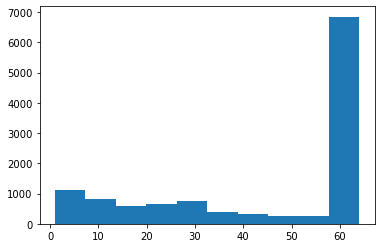

In [165]:
plt.hist(test_labels)

# rnd 생존기간 예측 

In [128]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
rnd_clf = RandomForestClassifier(n_estimators=700,random_state=42, criterion = 'entropy')
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)

RandomForestClassifier 0.63675


Text(0, 0.5, 'recall(%)')

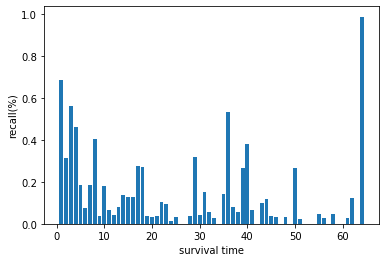

In [129]:
print(rnd_clf.__class__.__name__, accuracy_score(y_test, y_pred))

t = y_test.reset_index()
t['survival_pred'] = y_pred

a = []
for i in range(1,65):
    c = np.where((t['survival_time']==i) & (t['survival_pred']==i), 1, 0).sum() / t[t['survival_time']==i]['index'].count()
    a.append(c)

anp = np.array(a)
x = np.arange(1,65)
plt.bar(x,a)
plt.xlabel('survival time')
plt.ylabel('recall(%)')

RandomForestClassifier 0.63675
precision=0:  [26, 27, 53]


C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


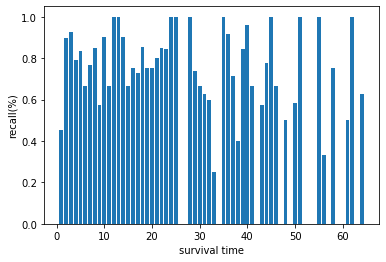

In [149]:
print(rnd_clf.__class__.__name__, accuracy_score(y_test, y_pred))

t = y_test.reset_index()
t['survival_pred'] = y_pred

a = []
day = []
for i in range(1,65):
    c = np.where((t['survival_time']==i) & (t['survival_pred']==i), 1, 0).sum() / t[t['survival_pred']==i]['index'].count()
    a.append(c)
    if c < 0.2:
        day.append(i)
anp = np.array(a)
x = np.arange(1,65)
plt.bar(x,a)
plt.xlabel('survival time')
plt.ylabel('precision(%)')

print('precision=0: ', day)
# recall 아니고 precision 그래프입니다. 

In [84]:
import pickle
pickle.dump(rnd_clf,open("rnd_all_feature_surv_0828.pickle.dat", "wb"))

(array([ 96.,  72.,  61.,  88.,  49.,  60.,  49., 185.,  95., 121.,  77.,
         62.,  60.,  51.,  84.,  77.,  64.,  71.,  77.,  83.,  98., 136.,
         99.,  58.,  61.,  44.,  72.,  69., 304.,  43.,  53.,   0.,  44.,
         33.,  56.,  47.,  63.,  52.,  34.,  44.,  37.,  28.,  26.,  34.,
         50.,  26.,  52.,  39.,  30.,  35.,  35.,  39.,  27.,  30.,  29.,
         38.,  37.,  54.,  61.,  27.,  43.,  35.,  28.,  20.]),
 array([ 1.     ,  1.96875,  2.9375 ,  3.90625,  4.875  ,  5.84375,
         6.8125 ,  7.78125,  8.75   ,  9.71875, 10.6875 , 11.65625,
        12.625  , 13.59375, 14.5625 , 15.53125, 16.5    , 17.46875,
        18.4375 , 19.40625, 20.375  , 21.34375, 22.3125 , 23.28125,
        24.25   , 25.21875, 26.1875 , 27.15625, 28.125  , 29.09375,
        30.0625 , 31.03125, 32.     , 32.96875, 33.9375 , 34.90625,
        35.875  , 36.84375, 37.8125 , 38.78125, 39.75   , 40.71875,
        41.6875 , 42.65625, 43.625  , 44.59375, 45.5625 , 46.53125,
        47.5    , 48.4

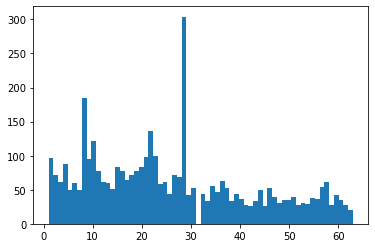

In [83]:
plt.hist(t[(t['survival_time']!=64) & (t['survival_pred']==64)]['survival_time'], bins=64)

# xgb 생존기간 예측 

In [76]:
import pickle
pickle.dump(xg_reg,open("xgb_all_feature_surv_0828.pickle.dat", "wb"))

In [69]:
find = act_40000_best.reset_index()
find = pd.merge(find, xt, on ='index', how='inner')

In [72]:
find[(find['survival_time']!=64) & (find['survival_pred']==64)].describe().T

,count,mean,std,min,25%,50%,75%,max
index,3701.0,1.980837e+04,1.167418e+04,1.000000e+00,9.464000e+03,1.980600e+04,3.012700e+04,3.998600e+04
acc_id,3701.0,6.466052e+04,3.793966e+04,5.000000e+00,3.102700e+04,6.477200e+04,9.810500e+04,1.304200e+05
class,3701.0,1.215166e+02,9.723363e+01,0.000000e+00,5.400000e+01,1.030000e+02,1.690000e+02,1.204000e+03
temp_cnt,3701.0,2.450487e+00,5.793915e+00,0.000000e+00,4.797278e-01,9.594555e-01,2.878367e+00,1.525534e+02
private_shop,3701.0,3.459624e+00,1.479959e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.091472e+01
level,3701.0,4.985258e+02,3.162129e+02,0.000000e+00,3.330000e+02,4.480000e+02,6.010000e+02,3.325000e+03
party_exp,3701.0,4.867669e+00,1.885782e+01,0.000000e+00,0.000000e+00,8.812019e-03,5.457050e-01,2.295414e+02
pledge_cnt,3701.0,3.777280e+00,3.183188e+01,0.000000e+00,0.000000e+00,0.000000e+00,6.418424e-02,1.023995e+03
random_attacker_cnt,3701.0,1.041812e+00,9.584288e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.097808e+02
random_defender_cnt,3701.0,2.809498e+00,9.105863e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.366129e+00,2.425282e+02


(array([ 89.,  67.,  56.,  87.,  42.,  56.,  46., 166.,  89., 118.,  75.,
         60.,  57.,  50.,  81.,  74.,  63.,  68.,  73.,  79.,  99., 134.,
         99.,  55.,  61.,  44.,  71.,  70., 265.,  44.,  52.,   0.,  46.,
         32.,  53.,  48.,  65.,  52.,  34.,  42.,  37.,  28.,  25.,  35.,
         47.,  25.,  46.,  39.,  29.,  34.,  34.,  39.,  27.,  30.,  29.,
         37.,  34.,  52.,  59.,  27.,  42.,  35.,  30.,  19.]),
 array([ 1.     ,  1.96875,  2.9375 ,  3.90625,  4.875  ,  5.84375,
         6.8125 ,  7.78125,  8.75   ,  9.71875, 10.6875 , 11.65625,
        12.625  , 13.59375, 14.5625 , 15.53125, 16.5    , 17.46875,
        18.4375 , 19.40625, 20.375  , 21.34375, 22.3125 , 23.28125,
        24.25   , 25.21875, 26.1875 , 27.15625, 28.125  , 29.09375,
        30.0625 , 31.03125, 32.     , 32.96875, 33.9375 , 34.90625,
        35.875  , 36.84375, 37.8125 , 38.78125, 39.75   , 40.71875,
        41.6875 , 42.65625, 43.625  , 44.59375, 45.5625 , 46.53125,
        47.5    , 48.4

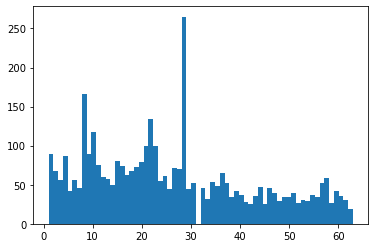

In [80]:
plt.hist(find[(find['survival_time']!=64) & (find['survival_pred']==64)]['survival_time'], bins=64)

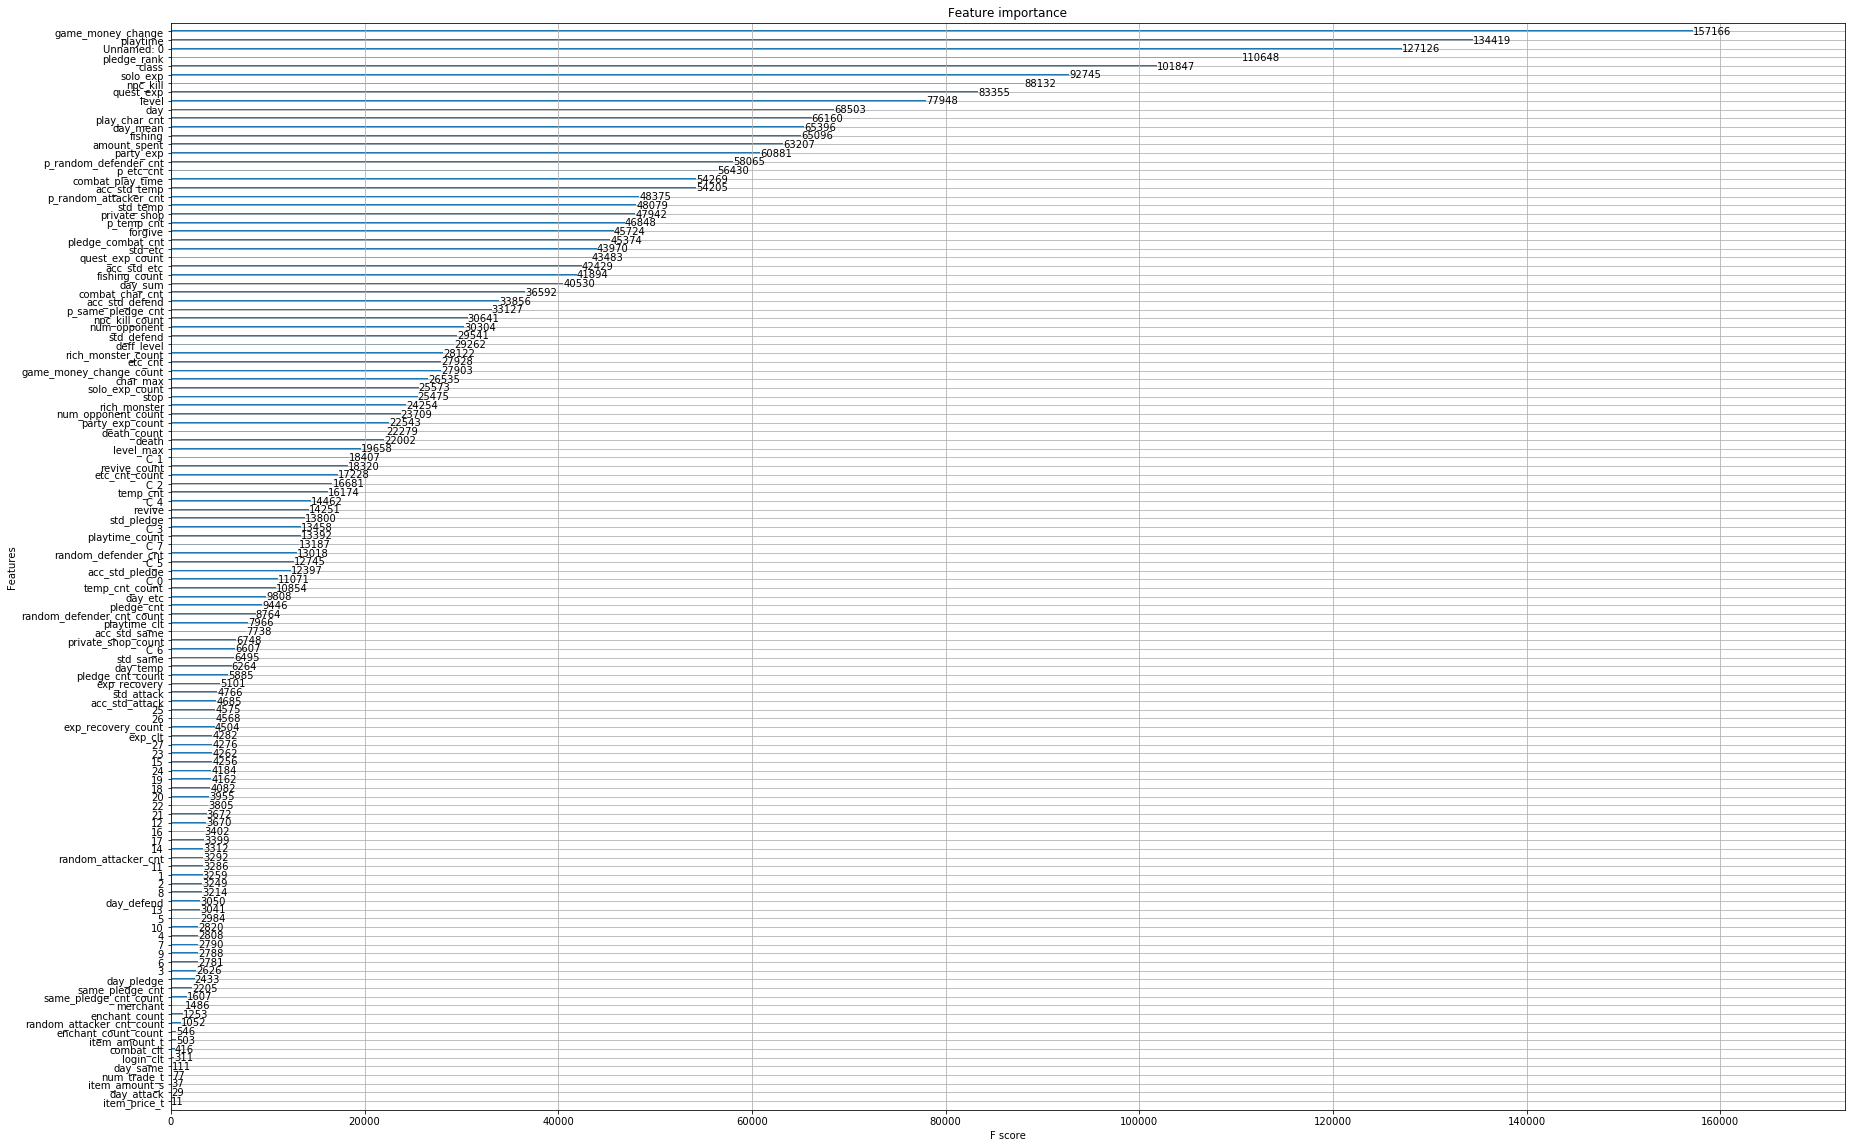

In [125]:
# 생존기간에 중요한 feature는? 
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(30,20))
xgb.plot_importance(xg_reg, importance_type='gain',ax=ax)
plt.show()
# Unnamed: 0 이 실수로 들어갔음.. 다시 해야 한다.

## xgb 생존기간 회귀

In [95]:
train=pd.read_csv('./train_allfeature.csv')

In [97]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(act_40000_best[act_40000_best.columns[1:]], survival_time['survival_time'], test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((21000, 129), (7000, 129), (12000, 129), (21000,), (7000,), (12000,))

In [106]:
import xgboost as xgb

params =   {
    'learning_rate': 0.02, 
    'gamma' : 0.3, 
    'min_child_weight' : 3,
    'nthread' : 15,
    'max_depth' : 30,
    'subsample' : 0.9,
    'eval_metric' : 'rmse',
    'colsample_bytree' : 0.8, 
    'num_boost_round' : 500,
    'n_estimators': 475,
    'max_leaves': 300,
    'objective':'reg:squarederror'
}

In [107]:
VALID = True
if VALID == True:

    tr_data = xgb.DMatrix(X_train, y_train)
    va_data = xgb.DMatrix(X_valid, y_valid)

    #del X_train, X_valid, y_train, y_valid  ; gc.collect()

    watchlist = [(tr_data, 'train'), (va_data, 'valid')]

    model = xgb.train(params, tr_data, 500, watchlist, maximize=False, 
                      early_stopping_rounds = 30, verbose_eval=50)

[0]	train-rmse:49.9906	valid-rmse:50.2696
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:20.6768	valid-rmse:25.1211
[100]	train-rmse:9.12138	valid-rmse:18.7443
[150]	train-rmse:4.45122	valid-rmse:17.5256
[200]	train-rmse:2.54506	valid-rmse:17.2971
[250]	train-rmse:1.70272	valid-rmse:17.2479
[300]	train-rmse:1.22336	valid-rmse:17.2336
[350]	train-rmse:0.895485	valid-rmse:17.2294
[400]	train-rmse:0.666132	valid-rmse:17.2268
[450]	train-rmse:0.51285	valid-rmse:17.2255
Stopping. Best iteration:
[464]	train-rmse:0.479411	valid-rmse:17.2248



In [110]:
pred = model.predict(xgb.DMatrix(X_test))

Text(0, 0.5, 'survival_pred')

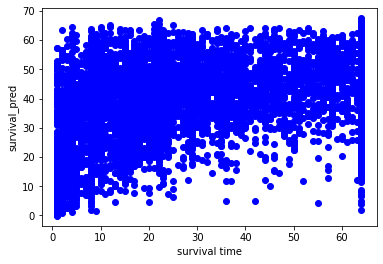

In [114]:
t = y_test.reset_index()
t['survival_pred'] = pred

plt.plot(t['survival_time'], t['survival_pred'],'bo')
plt.xlabel('survival time')
plt.ylabel('survival_pred')
# 오차가 너무 크다!!

# ..........................................

In [29]:
import pickle
xgb_survival_time1 = pickle.load(open("xgb_survival1(scale).pickle.dat", "rb"))

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [65]:
# 예측
data_for_surv = data_
surv_pred = xgb_survival_time1.predict(data_for_surv)

In [66]:
# test 데이터 불러와서 예측값 바꾸기
test1 = pd.read_csv('test1_predict.csv')

In [67]:
test1['total_spent'] = test1['amount_spent'] * test1['survival_time']
test1['survival_time'] = surv_pred
test1['amount_spent'] = test1['total_spent'] / test1['survival_time']

test1 = test1.drop('total_spent',axis=1)